In [143]:
from imutils import paths
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import scikitplot as skplt

In [144]:
path = "dataset"
imagespath = list(paths.list_images(path))
imagearr = []
labelarr = []

#Load images and labelarr into arrays
for imagepath in imagespath:
    image = cv2.imread(imagepath)
    image = cv2.resize(image, (224, 224))
    imagearr.append(image)
    label = imagepath.split(os.path.sep)[-2]
    labelarr.append(label)  

#Normalize the images and convert to numpy arrays
imagearr = np.array(imagearr) / 255.0
labelarr = np.array(labelarr)

# Convert labels from yes and no to 1 and 0
labelbinarizer = LabelBinarizer()
labelarr = labelbinarizer.fit_transform(labelarr)
labelarr = to_categorical(labelarr)

In [145]:
#Split data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(imagearr, labelarr, test_size=0.1,
                                                  random_state=42, stratify=labelarr)

# Mutate images so that the training data pool is larger
mutatedimages = ImageDataGenerator(fill_mode = 'nearest', rotation_range = 15)

# SVM

In [146]:
# Create a CNN
modelsvm = Sequential()
modelsvm.add(Conv2D(filters = 32, padding = "same",activation = "relu", kernel_size = 3, strides = 2,input_shape = (224,224,3)))
modelsvm.add(MaxPool2D(pool_size = (2,2), strides = 2))
modelsvm.add(Conv2D(filters = 32, padding = "same",activation = "relu",kernel_size = 3))
modelsvm.add(MaxPool2D(pool_size = (2,2), strides = 2))
modelsvm.add(Flatten())
modelsvm.add(Dense(128, activation = "relu"))
# Then convert it to a SVM using LinearSVM
modelsvm.add(Dense(2, kernel_regularizer = l2(0.01), activation = "linear"))

In [168]:
# Compile the model
modelsvm.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])
modelsvm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 56, 56, 32)        9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 25088)             0         
                                                                 
 dense_24 (Dense)            (None, 128)             

In [148]:
batchsize = 8
epochs = 10
trainingsteps = len(trainX)//batchsize
validationsteps = len(testX)//batchsize

In [159]:
# # Train the model and display results of different epochs
# historysvm = modelsvm.fit(mutatedimages.flow(trainX, trainY, batch_size= batchsize),
#  steps_per_epoch= trainingsteps, validation_data = (testX, testY), validation_steps= validationsteps, epochs= epochs)

Epoch 1/10
28/28 [==============================] - 4s 132ms/step - loss: 0.1971 - accuracy: 0.9361 - val_loss: 0.3246 - val_accuracy: 0.9231
Epoch 2/10
28/28 [==============================] - 3s 119ms/step - loss: 0.1716 - accuracy: 0.9452 - val_loss: 0.3994 - val_accuracy: 0.9231
Epoch 3/10
28/28 [==============================] - 3s 120ms/step - loss: 0.1142 - accuracy: 0.9543 - val_loss: 0.3855 - val_accuracy: 0.9231
Epoch 4/10
28/28 [==============================] - 3s 118ms/step - loss: 0.1391 - accuracy: 0.9498 - val_loss: 0.2168 - val_accuracy: 0.9231
Epoch 5/10
28/28 [==============================] - 3s 117ms/step - loss: 0.1316 - accuracy: 0.9635 - val_loss: 0.3914 - val_accuracy: 0.8846
Epoch 6/10
28/28 [==============================] - 3s 122ms/step - loss: 0.0965 - accuracy: 0.9863 - val_loss: 0.3380 - val_accuracy: 0.8846
Epoch 7/10
28/28 [==============================] - 3s 118ms/step - loss: 0.1226 - accuracy: 0.9635 - val_loss: 0.6339 - val_accuracy: 0.7692
Epoch 

In [165]:
save_path = './svmmodel.h5'
# modelsvm.save(save_path)
loadedsvmmodel = load_model(save_path)

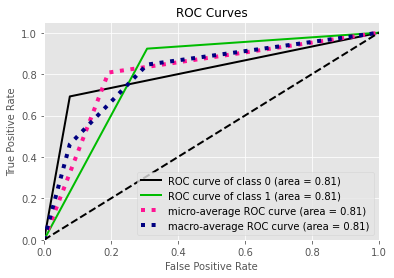

In [166]:
y_true = testY
y_probas = loadedsvmmodel.predict(testX, batch_size= batchsize)
predictions = np.argmax(y_probas, axis= 1)
skplt.metrics.plot_roc(predictions, testY)
plt.show()

In [167]:
#Evaluation
actualresults = np.argmax(testY, axis= 1)
predictions = loadedsvmmodel.predict(testX, batch_size= batchsize)
predictions = np.argmax(predictions, axis= 1)

print(classification_report(actualresults, predictions, target_names= labelbinarizer.classes_))
confmatrix = confusion_matrix(actualresults, predictions)

print(confmatrix)

#Print accuracy of model
total = sum(sum(confmatrix))
accuracy = (confmatrix[0, 0] + confmatrix[1, 1]) / total
print('Accuracy: {:.4f}'.format(accuracy))


              precision    recall  f1-score   support

          no       0.69      0.90      0.78        10
         yes       0.92      0.75      0.83        16

    accuracy                           0.81        26
   macro avg       0.81      0.82      0.81        26
weighted avg       0.83      0.81      0.81        26

[[ 9  1]
 [ 4 12]]
Accuracy: 0.8077


# VGG16

In [153]:
# Use Transfer Learning - take representations from a pretrained model(VGG16)
base = VGG16(weights = 'imagenet', input_tensor = Input(shape = (224, 224, 3)), include_top = False)

# Add needed layers
baseoutput = base.output
baseoutput = AveragePooling2D(pool_size = (4,4))(baseoutput)
baseoutput = Flatten(name = "flatten")(baseoutput)
baseoutput = Dense(64, activation = "relu")(baseoutput)
baseoutput = Dropout(0.5)(baseoutput)
baseoutput = Dense(2, activation = "softmax")(baseoutput)

baseinput = base.input

# Freeze the layers so that the next layers aren't trained from scratch each time
for layer in base.layers:
    layer.trainable = False

# Build and compile the model
modelvgg = Model(inputs = baseinput, outputs = baseoutput)
modelvgg.compile(optimizer = Adam(learning_rate = 1e-3), metrics = ['accuracy'], loss = 'binary_crossentropy')

modelvgg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [154]:
# Train the model and display results of different epochs
# historyvgg = modelvgg.fit(mutatedimages.flow(trainX, trainY, batch_size= batchsize),
#  steps_per_epoch= trainingsteps, validation_data = (testX, testY), validation_steps= validationsteps, epochs= epochs)

# modelvgg.fit(mutatedimages.flow(trainX, trainY, batch_size= batchsize),
#  steps_per_epoch= trainingsteps, validation_data = (testX, testY), validation_steps= validationsteps, epochs= epochs)

In [155]:
save_path2 = './vggmodel.h5'
# modelvgg.save(save_path2)
loadedvggmodel = load_model(save_path2)

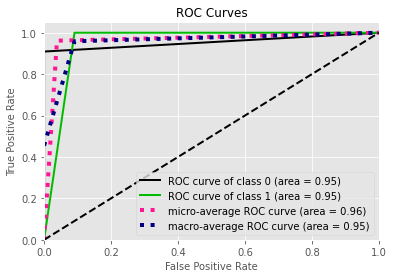

In [163]:
y_true = testY
y_probas = loadedvggmodel.predict(testX, batch_size= batchsize)
predictions = np.argmax(y_probas, axis= 1)
skplt.metrics.plot_roc(predictions, testY)
plt.show()

In [164]:
#Evaluation
actualresults = np.argmax(testY, axis= 1)
predictions = loadedvggmodel.predict(testX, batch_size= batchsize)
predictions = np.argmax(predictions, axis= 1)

print(classification_report(actualresults, predictions, target_names= labelbinarizer.classes_))
confmatrix = confusion_matrix(actualresults, predictions)

print(confmatrix)

#Print accuracy of model
total = sum(sum(confmatrix))
accuracy = (confmatrix[0, 0] + confmatrix[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))


              precision    recall  f1-score   support

          no       0.91      1.00      0.95        10
         yes       1.00      0.94      0.97        16

    accuracy                           0.96        26
   macro avg       0.95      0.97      0.96        26
weighted avg       0.97      0.96      0.96        26

[[10  0]
 [ 1 15]]
Accuracy: 0.9615


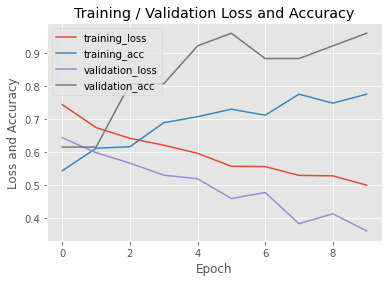

In [169]:
#Plot loss/accuracy results of different model epochs
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, epochs), historyvgg.history["loss"], label= "training_loss")
plt.plot(np.arange(0, epochs), historyvgg.history["accuracy"], label= "training_acc")
plt.plot(np.arange(0, epochs), historyvgg.history["val_loss"], label= "validation_loss")
plt.plot(np.arange(0, epochs), historyvgg.history["val_accuracy"], label= "validation_acc")

plt.title("Training / Validation Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss and Accuracy")
plt.legend()
plt.savefig("plot.jpg")